In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from context import pypho
import matplotlib.pyplot as plt

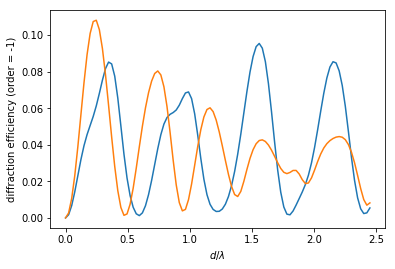

In [12]:
wavelength = 1
lattice_constant = 1

# incident angles
theta = np.pi/18
phi = 0

n = 2.04  # refractive index

diffraction_order = -1  # diffraction order

# range of thicknesses
d_num = 100
d_range = np.linspace(0, 5, d_num)/n

# create simulation object
frequency = 2*np.pi/wavelength
num_order = 50
momentum = frequency*np.array([np.sin(theta)*np.cos(phi),
                               np.sin(theta)*np.sin(phi)])
sim = pypho.simulation_1d.new(frequency, momentum, num_order)
sim.stack.set_lattice_constant(lattice_constant)
sim.stack.define_material('vacuum', 1)
sim.stack.define_material('SiO2', n**2)
sim.stack.define_pattern('grating', ['SiO2', 'vacuum'], [.5, .5])
sim.stack.add_layers(['vacuum', 'grating', 'SiO2'], [None, 1, None])

rp = np.zeros(d_num)
rs = np.zeros(d_num)
for i, d in enumerate(d_range):
    sim.stack.set_layer_thickness(1, d)
    sim.run()
    rs[i] = np.abs(sim.get_reflection(polarization_in=[1,0], polarization_out=[1,0],
                                        order_out=diffraction_order))**2
    rp[i] = np.abs(sim.get_reflection(polarization_in=[0,1], polarization_out=[0,1],
                                        order_out=diffraction_order))**2

plt.plot(d_range, rs);
plt.plot(d_range, rp);
plt.xlabel("$d/\lambda$");
plt.ylabel(f"diffraction efficiency (order = {diffraction_order})");